### logistic回归

> 理论 《统计学习方法》第六章 逻辑斯谛回归模型
> 
> 代码 numpy version && torch version
>
> Python3.7

#### sigmod函数

$$
\sigma(x) = {1\over {1+e^{-x}}}
$$

#### 二项logistic回归模型

Y取0|1

通过一个线性，然后再logistic函数，转换为条件概率分布P(Y|X)

$$
P(Y=1|X) = {e^{w\cdot x + b}\over {1+e^{w\cdot x + b}}}
$$

$$
P(Y=1|X) = {1\over {1+e^{w\cdot x + b}}}
$$

#### 几率odds

几率是指该事件发生与不发生概论的比值,发生概率为p,则几率是$p\over{1-p}$。对数几率是$logit(p) = log{p\over {1-p}}$。对上述的logistic回归，几率是$w\cdot x + b$,也就是说输出Y=1的对数几率是输入X的线性函数。

#### 交叉熵损失函数

$$
L(y,\hat{y}) = - [y\log \hat{y} + (1-y)\log(1-\hat{y})]
$$


#### 参数估计

使用极大似然法估计模型参数。

假设$P(Y=1|x) = \pi(x),P(Y=0|x)=1-\pi(x)$。



则有似然函数$\Pi [\pi(x_i)]^{y_i}[1-\pi(x_i)]^{1-y_i}$。

（解释：当$y_i=0$时候，需要最大$[1-\pi(x_i)]^{1-y_i}$。$y_i=1$时同）。



对数似然函数(其实就是**负的**交叉熵损失函数)
$$
L(w,b) = \Sigma [y_i\ \log\pi(x_i) + (1-y_i)\ \log (1-\pi(x_i)]\\ =\Sigma [y_i\ \log{\pi(x_i)\over 1-\pi(x_i)} + \log(1-\pi(x_i))]\\
=\Sigma [y_i(-(w\cdot x_i + b)) - log(1+e^{-(w\cdot x_i + b)})]
$$
然后$L(w,b)$对$w,b$求导，使用梯度下降法更新$w,b$便可以得到参数估计值
$$
\frac{\partial L(w,b)}{\partial w} = \varSigma{(-y_i\cdot x_i - {e^{-(w\cdot x_i + b)}\cdot -x_i\over{1+ e^{-(w\cdot x_i + b)}}})} = \varSigma x_i (\sigma(x_i) - y_i)
\\
\frac{\partial L(w,b)}{\partial b} = \varSigma{(-y_i - {e^{-(w\cdot x_i + b)}\cdot -x_i\over{1+ e^{-(w\cdot x_i + b)}}})} = {\varSigma (\sigma(x_i)-y_i)}
$$


In [29]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.utils.data as Data
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score
import random

In [30]:
def draw_fig(x,y,w,b):
    plt.figure(dpi=64,figsize=(4,4))

    plt.scatter(x[:,0],x[:,1],c=y)

    # 画分离超平面
    if w is not None:
        x1 = np.arange(-1, 4, 0.1)
        x2 = (w[0] * x1 + b) / (-w[1])
        plt.plot(x1,x2)

    plt.show()

In [31]:
x_train,y_train = make_blobs(n_samples=200,
                 n_features=2,
                 centers=2,
                 cluster_std=1,
                 random_state=8)

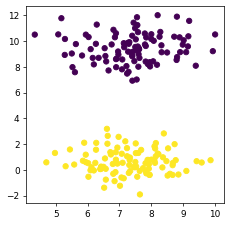

In [32]:
draw_fig(x_train,y_train,None,None)

In [33]:
# x_train = np.array([[3.,3.],[4,3],[5,5],[1,1],[0,0],[1,0]])
# y_train = np.array([1,1,1,0,0,0])

epoch 5 % dw is [-0.00080945 -0.00037774],db is -0.00
epoch 5 % w is [ 2.88589051 -4.89094582],b is 0.42

epoch 10 % dw is [-0.00078391 -0.00036577],db is -0.00
epoch 10 % w is [ 2.88986049 -4.88909335],b is 0.42

epoch 15 % dw is [-0.00075992 -0.00035451],db is -0.00
epoch 15 % w is [ 2.8937075  -4.88729855],b is 0.42

epoch 20 % dw is [-0.00073735 -0.00034392],db is -0.00
epoch 20 % w is [ 2.89743885 -4.88555801],b is 0.42

epoch 25 % dw is [-0.00071606 -0.00033394],db is -0.00
epoch 25 % w is [ 2.90106125 -4.88386858],b is 0.42

epoch 30 % dw is [-0.00069596 -0.00032451],db is -0.00
epoch 30 % w is [ 2.90458082 -4.88222738],b is 0.42

epoch 35 % dw is [-0.00067695 -0.00031559],db is -0.00
epoch 35 % w is [ 2.90800319 -4.88063179],b is 0.42

epoch 40 % dw is [-0.00065894 -0.00030714],db is -0.00
epoch 40 % w is [ 2.91133354 -4.87907938],b is 0.42

epoch 45 % dw is [-0.00064186 -0.00029912],db is -0.00
epoch 45 % w is [ 2.91457664 -4.8775679 ],b is 0.42

epoch 50 % dw is [-0.00062563 

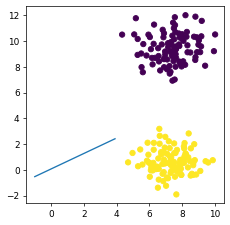

In [34]:
"""
numpy实现
"""
def Sigmoid(x):
    return 1 / (1+np.exp(-x))

def BCELoss(y,yhat):
    return -(y*np.log(yhat)+(1-y)*np.log(1-yhat))

lr = 1
w = np.zeros(x_train.shape[1])
b = 0
epochs = 60
size = len(x_train)

yhat_list = np.zeros_like(y_train,dtype=float)

for epoch in range(1,epochs+1):
    for i,v in enumerate(x_train):
        y_hat = float(Sigmoid( (v*w).sum() + b ))
        yhat_list[i] = y_hat
    db = (yhat_list - y_train).sum() / size
    dw = np.zeros_like(w)
    for ix in range(len(dw)):
        dw[ix] = x_train[:,ix].T.dot((yhat_list-y_train).T)
    dw /= size
    w -= lr * dw
    b -= lr * db
    if epoch % 5 == 0:
        print("epoch {} % dw is {},db is {:.2f}".format(epoch,dw,db))
        print("epoch {} % w is {},b is {:.2f}".format(epoch,w,b))
        print()
 
print("\nfinally get w is {}, b is {:.2f}".format(w,b))

draw_fig(x_train,y_train,w,b)

epoch 20 % loss 0.00
epoch 40 % loss 0.00
epoch 60 % loss 0.00
epoch 80 % loss 0.00
epoch 100 % loss 0.00

finally get w is [ 1.6854587 -2.5433536], b is 0.36


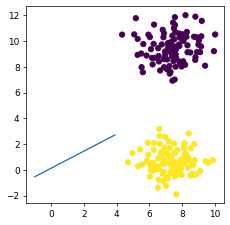

In [35]:
"""
pytorch实现
"""
class LogisticReg(nn.Module):
    def __init__(self,n):
        super(LogisticReg,self).__init__()
        self.linear = nn.Linear(n,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

lr = 0.1
epochs = 100
batch_size = 4

x_t = torch.from_numpy(x_train).float()
y_t = torch.from_numpy(y_train).float()
dataset = Data.TensorDataset(x_t,y_t)
data_iter = Data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0 # 多线程，windows需要设置为0
)

net = LogisticReg(x_train.shape[1])
# 模型参数初始化
nn.init.normal_(net.linear.weight,mean=0,std=1)
nn.init.constant_(net.linear.bias,val=0)
loss = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(),lr=lr)

for epoch in range(1,epochs+1):
    for x,y in data_iter:
        y_hat = net(x)
        y_hat = y_hat.squeeze()     # 拉伸为一维向量
        l = loss(y_hat,y)

        optimizer.zero_grad()
        l.backward()
        optimizer.step()

    if epoch%20==0:
        print('epoch {} % loss {:.2f}'.format(epoch,l.item()))

w = net.linear.weight[0].detach().numpy()
b = net.linear.bias.data[0].numpy()
print("\nfinally get w is {}, b is {:.2f}".format(w,b))

draw_fig(x_train,y_train,w,b)